<a href="https://colab.research.google.com/github/rubengamarro/practicas-aprendizaje-supervisado/blob/main/5_TAREA_Algoritmos_de_regresi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EJERCICIO 1

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [261]:
#Vamos a cambiarle el nombre a las columnas para que después no se superpongan en las gráficas que relacionan rasgos
nombresColumnas = ['Nº', 'fecha transacción', 'edad casa', 'min distancia a MTR', 'nº de minimarkets', 'latitud', 'longitud', 'precio vivienda x unidad sup.']
df = pd.read_excel('https://github.com/rubengamarro/practicas-aprendizaje-supervisado/raw/main/data/RealEstate.xlsx', names=nombresColumnas)
df

,Nº,fecha transacción,edad casa,min distancia a MTR,nº de minimarkets,latitud,longitud,precio vivienda x unidad sup.
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.666667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250000,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000000,8.1,104.81010,5,24.96674,121.54067,52.5


**Apartado a**

In [262]:
#Elegimos los rasgos a estudiar, que en principio van a ser todos
colElegidas = ['Nº', 'fecha transacción', 'edad casa', 'min distancia a MTR', 'nº de minimarkets', 'latitud', 'longitud', 'precio vivienda x unidad sup.']

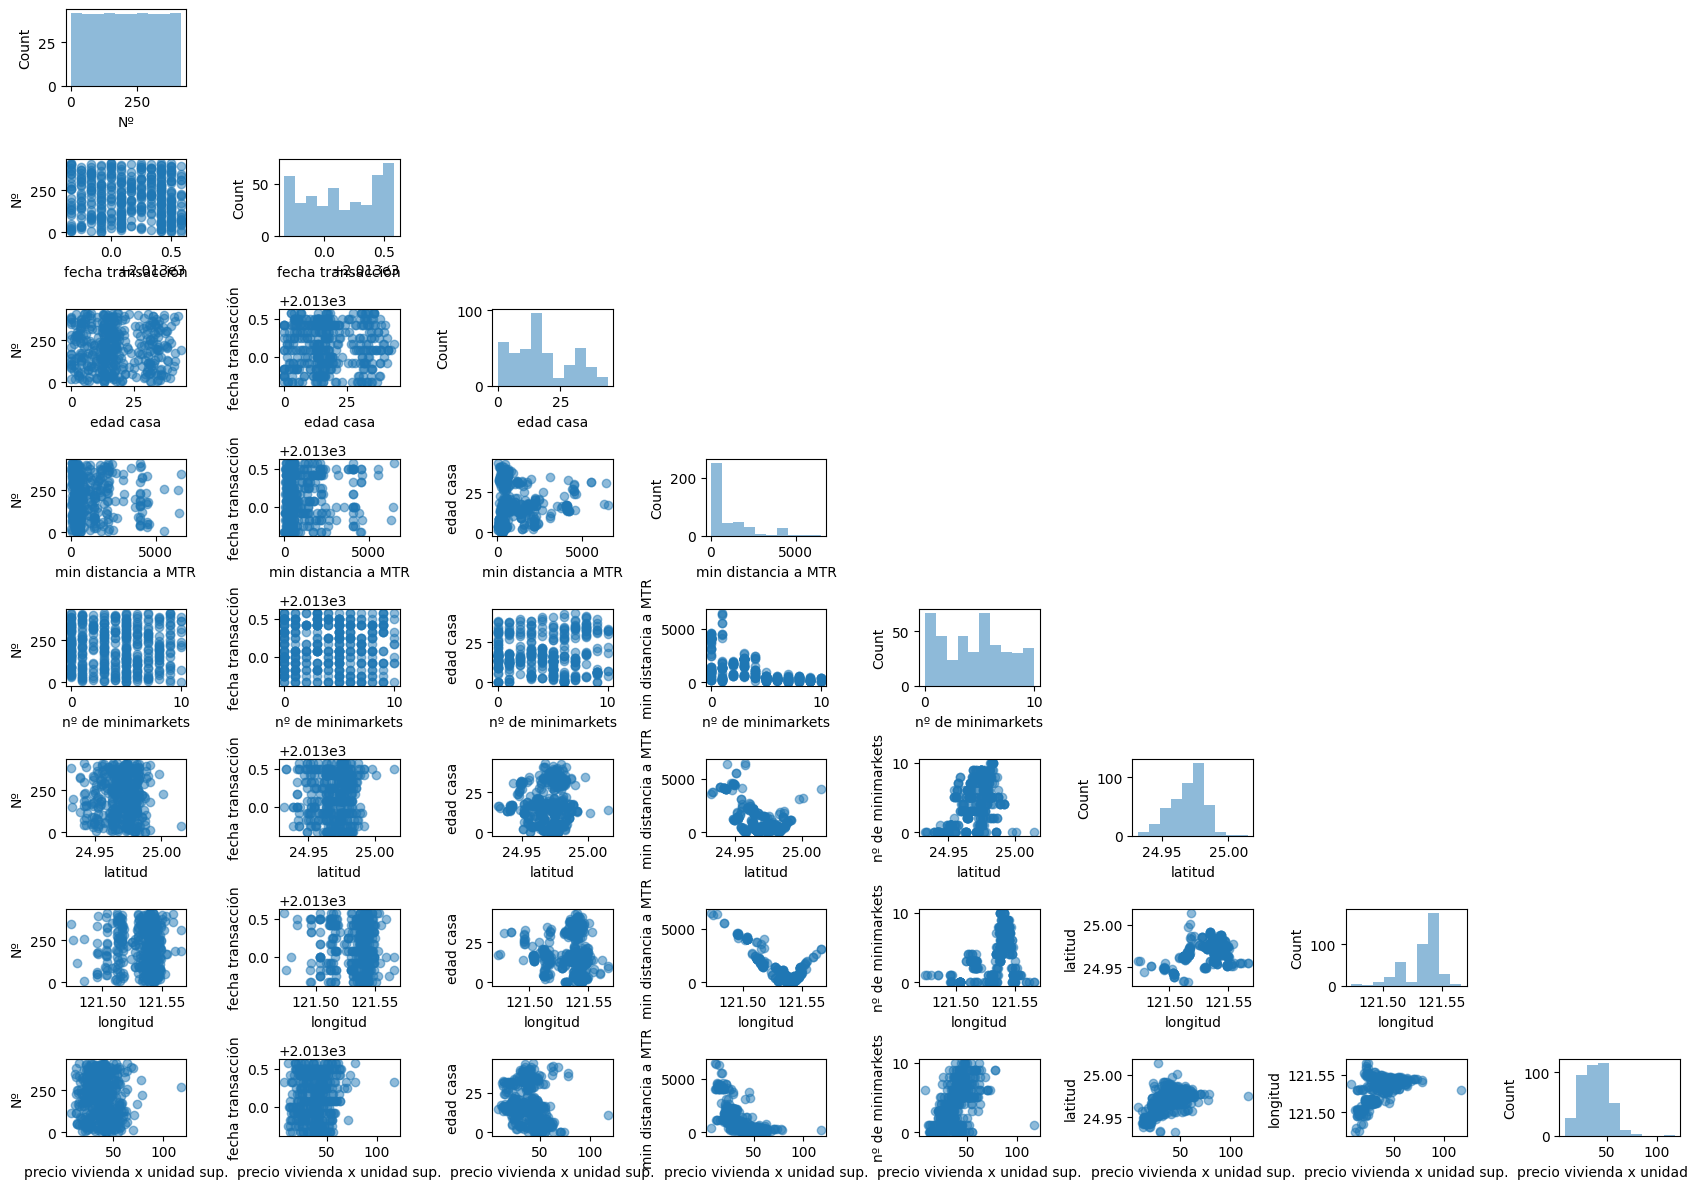

In [263]:
#Dibujamos las gráficas que relacionan los pares de rasgos
from mlxtend.plotting import scatterplotmatrix

scatterplotmatrix(df[colElegidas].values, figsize=(17, 12),
                   names=colElegidas, alpha=0.5)
plt.tight_layout()
plt.show()

En estas gráficas podemos ver que algunos rasgos presentan correlación, por ejemplo, la distancia al metro más cercano presenta una correlación negativa con los rasgos de latitud, longitud, precio de la vivienda por unidad de superficie y nº de minimarkets. Por otro lado, podemos ver algunos pares de rasgos que presentan correlación positiva, como puede ser el nº de minimarkets con la latitud, la longitud y el precio de la vivienda por unidad de superficie.

**Apartado b**

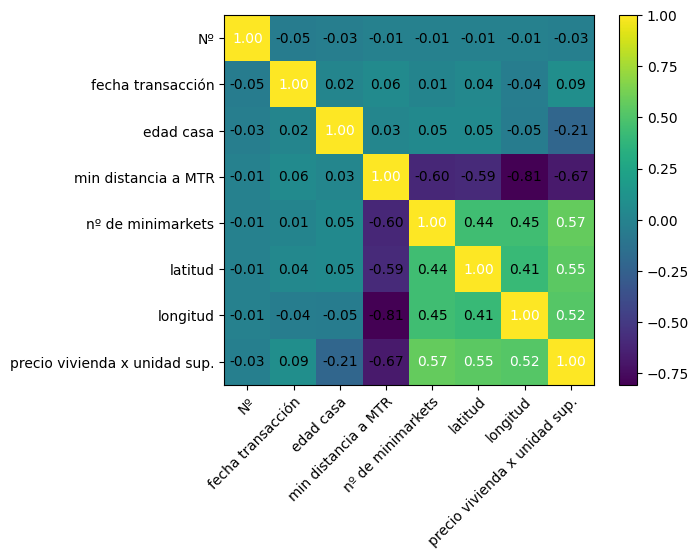

In [264]:
from mlxtend.plotting import heatmap

matrizCorr = np.corrcoef(df[colElegidas].values.T)
mapaCalor = heatmap(matrizCorr, row_names=colElegidas, column_names=colElegidas)
plt.show()

Como podemos ver en la matriz de correlación, se confirma lo dicho en el apartado anterior, siendo el atributo más prometedor para realizar una regresión lineal la distancia al metro más cercano, ya que presenta el valor más cercano a 1 en valor absoluto para la correlación con el precio de la vivienda. Es decir, aunque la correlación sea negativa, es el valor más con más correlación con el rasgo que queremos estudiar, el precio de la vivienda por unidad de superficie. El menos prometedor, sin contar la columna que los enumera, sería la fecha de transacción, ya que es el rasgo con correlación más cercana a 0 para el precio de la vivienda. Esto tiene sentido, ya que el precio por unidad de superficie no va a variar mucho en función de la fecha de compra de la vivienda, mientras que la proximidad a una estación de metro si que afectará, aumentando el precio a aquellas viviendas que tengan un metro cerca.

**Apartado c**

In [265]:
#Implementamos una clase para la regresión lineal

class RegresionLineal(object):

    def __init__(self, eta=0.0001, n_epoc=100):
        self.eta = eta
        self.n_epoc = n_epoc

    def entrenar(self, X, y):
        num_rasgos = X.shape[1]
        num_muestras = X.shape[0]
        self.w = np.zeros(num_rasgos + 1)
        self.ECM_historico = []

        for i in range(self.n_epoc):
            #Calculamos errores para todas las muestras
            errores = (y - self.potencial(X))
            #Ajustamos los pesos sinápticos según descenso por el gradiente:
            self.w[0] += np.exp(-i/self.n_epoc) * self.eta * errores.sum()
            self.w[1:] += np.exp(-i/self.n_epoc) * self.eta * X.T.dot(errores)

            #Calculamos y guardamos ECM
            ECM_actual = (errores**2).sum() / num_muestras
            self.ECM_historico.append(ECM_actual)
        return self

    def potencial(self, X):
        return np.dot(X, self.w[1:]) + self.w[0]

    def prediccion(self, X):
        return self.potencial(X)

In [266]:
#Realizamos la regresión lineal simple con el rasgo más prometedor, en nuestro caso la distancia al metro más cercano
from sklearn.preprocessing import StandardScaler

# Preparamos muestras
X = df[['min distancia a MTR']].values
y = df['precio vivienda x unidad sup.'].values

# Estandarizamos rasgos y salida deseada:
xEstandarizador = StandardScaler()
yEstandarizador = StandardScaler()
X_est = xEstandarizador.fit_transform(X)
#OjO: Estandarizamos valores objetivo, aplicamos función flatten para pasar a
#vector de una dimensión:
y_est = yEstandarizador.fit_transform(y[:, np.newaxis]).flatten()

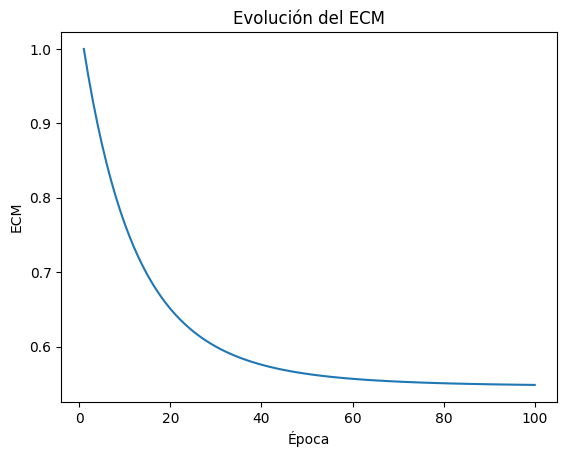

In [267]:
# Entrenamos regresión lineal
regLin = RegresionLineal()
regLin.entrenar(X_est, y_est)

# Dibujamos curva de rendimiento
plt.plot(range(1, regLin.n_epoc+1), regLin.ECM_historico)
plt.ylabel('ECM')
plt.xlabel('Época')
plt.title('Evolución del ECM')
plt.show()

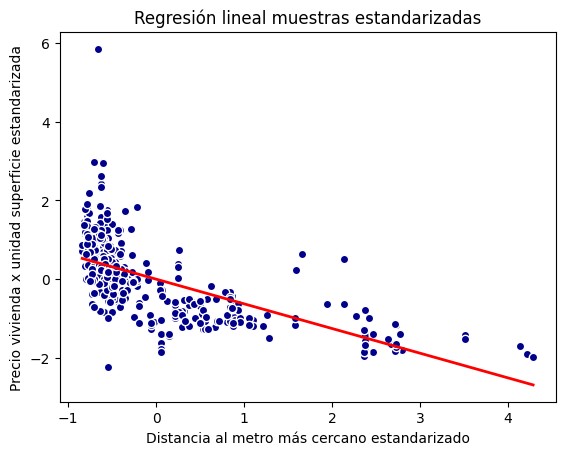

In [268]:
# Pintamos muestras:
plt.scatter(X_est, y_est, c='darkblue', edgecolor='white')

# Pintamos recta de regresión:
XInicioFinRectaReg = np.array([X_est.min(), X_est.max()])
YInicioFinRectaReg = regLin.prediccion(XInicioFinRectaReg[:, np.newaxis])
plt.plot(XInicioFinRectaReg, YInicioFinRectaReg, color='red', lw=2)

plt.title('Regresión lineal muestras estandarizadas')
plt.xlabel('Distancia al metro más cercano estandarizado')
plt.ylabel('Precio vivienda x unidad superficie estandarizada')
plt.show()

Obtenemos un resultado adecuado, ya que como dijimos anteriormente, ahora se confirma que cuánto mayor es la distancia al metro más cercano, el precio de la superficie de la vivienda será más barato.

**Apartado d**

Calculamos el precio de la vivienda por unidad de superficie con los rasgos sin estandarizar, en este caso elegimos que la distancia al metro más cercana sea 100.

In [269]:
distanciaMetro = 100
distanciaMetroEst = xEstandarizador.transform(np.array([[distanciaMetro]]))
precioViviendaEst = regLin.prediccion(distanciaMetroEst)
print("El precio de la vivienda por unidad de superficie estimada para una distancia al metro más cercano de %.3f es: %.3f"%
      (distanciaMetro, yEstandarizador.inverse_transform(precioViviendaEst.reshape(-1,1))[0,0]))

El precio de la vivienda por unidad de superficie estimada para una distancia al metro más cercano de 100.000 es: 44.630


Obtenemos que el precio de la vivienda para esta distancia será de 44.630 por unidad de superficie.

#EJERCICIO 2

**Apartado a y b**

In [270]:
# Preparamos muestras:
X = df[['min distancia a MTR']].values
y = df['precio vivienda x unidad sup.'].values

In [271]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Preparamos muestras:
X_ent, X_test, y_ent, y_test = train_test_split(X, y, test_size=0.3,
                                                random_state=0)

In [272]:
from sklearn.linear_model import RANSACRegressor

# Creamos y entrenamos objeto RANSAC
ransac = RANSACRegressor(LinearRegression(), max_trials=150, min_samples=20,
                          loss='absolute_error', residual_threshold=5, #Con 1 ya se conseguía 20 muestras de entrenamiento típicas, pero me parecía muy poco considerando que hay casi 300 muestras de entrenamiento
                          random_state=0)
ransac.fit(X_ent, y_ent)

RANSACRegressor(estimator=LinearRegression(), max_trials=150, min_samples=20,
                random_state=0, residual_threshold=5)

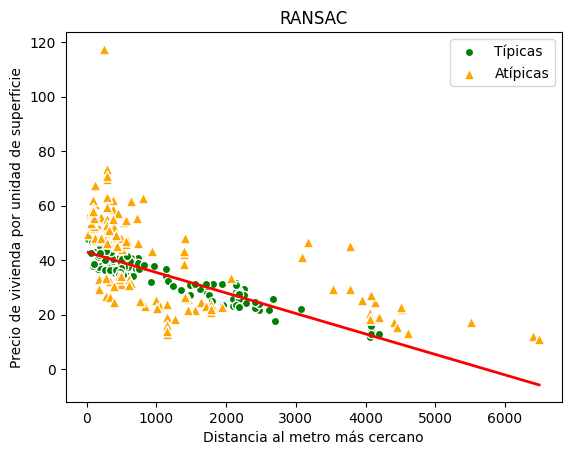

In [273]:
# Apuntamos las muestras típicas y atípicas:
mascaraMuestrasTípicas = ransac.inlier_mask_
mascaraMuestrasAtípicas = np.logical_not(mascaraMuestrasTípicas)

# Pintamos muestras típicas y atípicas:
plt.scatter(X_ent[mascaraMuestrasTípicas], y_ent[mascaraMuestrasTípicas],
             c='green', edgecolor='white',
             marker='o', label='Típicas')
plt.scatter(X_ent[mascaraMuestrasAtípicas], y_ent[mascaraMuestrasAtípicas],
             c='orange', edgecolor='white',
             marker='^', label='Atípicas', s=60)

# Pintamos recta de regresión:
XInicioFinRectaRANSAC = np.array([X_ent.min()-1, X_ent.max()+1])
yInicioFinRectaRANSAC = ransac.predict(XInicioFinRectaRANSAC[:, np.newaxis])
plt.plot(XInicioFinRectaRANSAC, yInicioFinRectaRANSAC, color='red', lw=2)

plt.title('RANSAC')
plt.xlabel('Distancia al metro más cercano')
plt.ylabel('Precio de vivienda por unidad de superficie')
plt.legend(loc='best')
plt.show()

In [274]:
print("Número de muestras típicas: %d" % mascaraMuestrasTípicas.sum())
print("Número de muestras atípicas: %d" % mascaraMuestrasAtípicas.sum())

Número de muestras típicas: 142
Número de muestras atípicas: 147


**Apartado c**

In [275]:
# Entrenamos regresión lineal y predecimos salidas de las muestras:
regLinSKL = LinearRegression()
regLinSKL.fit(X_ent, y_ent)
y_ent_pred = regLinSKL.predict(X_ent)
y_test_pred = regLinSKL.predict(X_test)

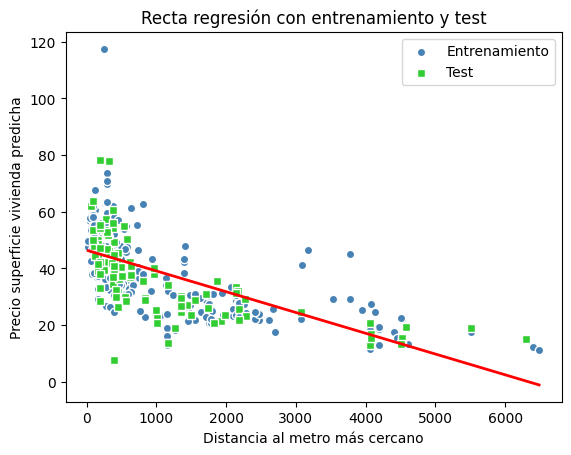

In [276]:
# Pintamos muestras:
plt.scatter(X_ent, y_ent,
            c='steelblue', marker='o', edgecolor='white',
            label='Entrenamiento')
plt.scatter(X_test, y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test')

# Calculamos y pintamos recta regresión:
XInicioFinRectaReg = np.array([X.min(), X.max()])
YInicioFinRectaReg = regLinSKL.predict(XInicioFinRectaReg[:, np.newaxis])
plt.plot(XInicioFinRectaReg, YInicioFinRectaReg, color='red', lw=2)

plt.xlabel('Distancia al metro más cercano')
plt.ylabel('Precio superficie vivienda predicha')
plt.legend(loc='best')
plt.title('Recta regresión con entrenamiento y test')
plt.show()

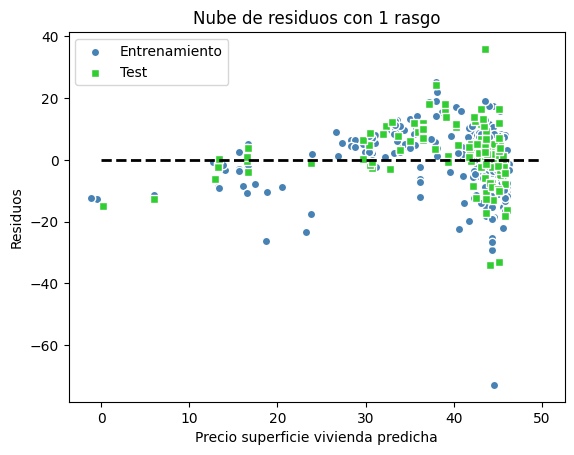

In [277]:
# Pintamos muestras en una nube de residuos:
plt.scatter(y_ent_pred, y_ent_pred - y_ent,
            c='steelblue', marker='o', edgecolor='white',
            label='Entrenamiento')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test')
plt.xlabel('Precio superficie vivienda predicha')
plt.ylabel('Residuos')
plt.legend(loc='best')
plt.hlines(y=0, xmin=0, xmax=50, color='black', lw=2, linestyle='dashed')
plt.title('Nube de residuos con 1 rasgo')
plt.show()

**Apartado d**

Observando la nube, podemos ver que los valores predichos entre 40 y 47 son los más fiables, ya que es donde los puntos están más concentrados y los residuos son cercanos a 0.

**Apartado e**

In [278]:
from sklearn.metrics import mean_squared_error

print('Error Cuadrático Medio (ECM): \n\tEntrenamiento = %.3f \n\tTest = %.3f' % (
        mean_squared_error(y_ent, y_ent_pred),
        mean_squared_error(y_test, y_test_pred)))

Error Cuadrático Medio (ECM): 
	Entrenamiento = 103.895 
	Test = 94.837


In [279]:
from sklearn.metrics import r2_score

print('Coeficiente de determinación R^2: \n\tEntrenamiento = %.3f \n\tTest = %.3f' %
       (r2_score(y_ent, y_ent_pred), r2_score(y_test, y_test_pred)))

Coeficiente de determinación R^2: 
	Entrenamiento = 0.454 
	Test = 0.444


#EJERCICIO 3

**Apartado a**

In [280]:
# Preparamos muestras:
X = df[['fecha transacción', 'edad casa', 'min distancia a MTR', 'nº de minimarkets', 'latitud', 'longitud']].values
y = df['precio vivienda x unidad sup.'].values

In [281]:
from sklearn.model_selection import train_test_split

# Preparamos muestras:
X_ent, X_test, y_ent, y_test = train_test_split(X, y, test_size=0.3,
                                                random_state=0)

In [282]:
# Entrenamos regresión lineal y predecimos salidas de las muestras:
regLinSKL = LinearRegression()
regLinSKL.fit(X_ent, y_ent)
y_ent_pred = regLinSKL.predict(X_ent)
y_test_pred = regLinSKL.predict(X_test)

In [283]:
from sklearn.metrics import mean_squared_error

print('Error Cuadrático Medio (ECM): \n\tEntrenamiento = %.3f \n\tTest = %.3f' % (
        mean_squared_error(y_ent, y_ent_pred),
        mean_squared_error(y_test, y_test_pred)))

Error Cuadrático Medio (ECM): 
	Entrenamiento = 79.874 
	Test = 71.576


In [284]:
from sklearn.metrics import r2_score

print('Coeficiente de determinación R^2: \n\tEntrenamiento = %.3f \n\tTest = %.3f' %
       (r2_score(y_ent, y_ent_pred), r2_score(y_test, y_test_pred)))

Coeficiente de determinación R^2: 
	Entrenamiento = 0.581 
	Test = 0.580


Como podemos ver, al utilizar todos los rasgos, el ECM disminuye y el coeficiente de determinación es más cercano a 1, por lo que obtenemos una mejor predicción.

**Apartado b**


In [285]:
from sklearn.linear_model import Lasso

L1 = Lasso(alpha=0.1)

In [286]:
L1.fit(X_ent, y_ent)
y_train_pred = L1.predict(X_ent)
y_test_pred = L1.predict(X_test)

In [287]:
print('Error Cuadrático Medio (ECM): \n\tEntrenamiento = %.3f \n\tTest = %.3f' % (
        mean_squared_error(y_ent, y_ent_pred),
        mean_squared_error(y_test, y_test_pred)))

Error Cuadrático Medio (ECM): 
	Entrenamiento = 79.874 
	Test = 75.446


In [288]:
print('Coeficiente de determinación R^2: \n\tEntrenamiento = %.3f \n\tTest = %.3f' %
       (r2_score(y_ent, y_ent_pred), r2_score(y_test, y_test_pred)))

Coeficiente de determinación R^2: 
	Entrenamiento = 0.581 
	Test = 0.557


In [289]:
L1.coef_

array([ 4.82834744, -0.2592977 , -0.00574807,  1.10472745,  0.        ,
       -0.        ])

In [290]:
print('Cantidad de rasgos anulados = %d ' % (
        L1.coef_.shape[0] - np.count_nonzero(L1.coef_)))

Cantidad de rasgos anulados = 2 


**Apartado c**

Considerando los resultados del apartado anterior, tendríamos que los rasgos menos relevantes son lo de posición de la vivienda, ya que son los rasgos con coeficientes que se anulan, y por tanto los rasgos que elimina el modelo.

#EJERCICIO 4

**Apartado a y b**

In [291]:
# Preparamos muestras:
X = df[['min distancia a MTR']].values
y = df['precio vivienda x unidad sup.'].values

In [292]:
from sklearn.model_selection import train_test_split

# Preparamos muestras:
X_ent, X_test, y_ent, y_test = train_test_split(X, y, test_size=0.3,
                                                random_state=0)

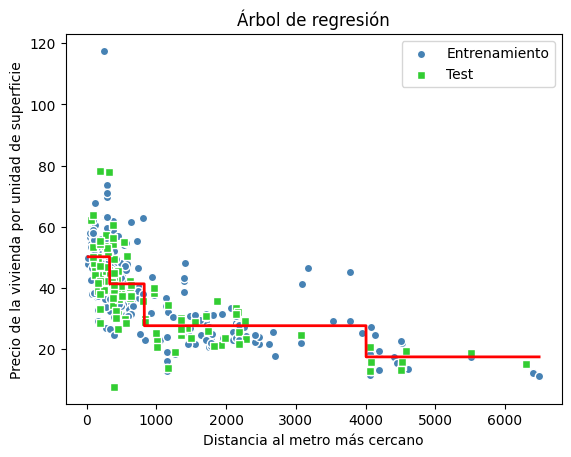

In [293]:
from sklearn.tree import DecisionTreeRegressor

# Entrenamos el árbol:
arbol = DecisionTreeRegressor(max_depth=2)
arbol.fit(X_ent, y_ent)
y_train_pred = arbol.predict(X_ent)
y_test_pred = arbol.predict(X_test)

# Pintamos las muestras:
plt.scatter(X_ent, y_ent,
            c='steelblue', marker='o', edgecolor='white',
            label='Entrenamiento')
plt.scatter(X_test, y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test')

#Para dibujar la recta a trozos es necesario calcular los puntos de todo el
#intervalo, no sólo el principio y el final como en algunos casos anteriores
XRango = np.arange(X.min(), X.max()+1, 1)
YRectaTrozosPred = arbol.predict(XRango[:, np.newaxis])

plt.plot(XRango, YRectaTrozosPred, color='red', lw=2)

plt.title('Árbol de regresión')
plt.xlabel('Distancia al metro más cercano')
plt.ylabel('Precio de la vivienda por unidad de superficie')
plt.legend(loc = 'best')

plt.show()

**Apartado c**

In [294]:
print('Error Cuadrático Medio (ECM): \n\tEntrenamiento = %.3f \n\tTest = %.3f' % (
        mean_squared_error(y_ent, y_ent_pred),
        mean_squared_error(y_test, y_test_pred)))

Error Cuadrático Medio (ECM): 
	Entrenamiento = 79.874 
	Test = 66.038


In [295]:
print('Coeficiente de determinación R^2: \n\tEntrenamiento = %.3f \n\tTest = %.3f' %
       (r2_score(y_ent, y_ent_pred), r2_score(y_test, y_test_pred)))

Coeficiente de determinación R^2: 
	Entrenamiento = 0.581 
	Test = 0.613


#EJERCICIO 5

In [296]:
# Preparamos muestras:
X = df[['fecha transacción', 'edad casa', 'min distancia a MTR', 'nº de minimarkets', 'latitud', 'longitud']].values
y = df['precio vivienda x unidad sup.'].values

In [297]:
from sklearn.model_selection import train_test_split

# Preparamos muestras:
X_ent, X_test, y_ent, y_test = train_test_split(X, y, test_size=0.3,
                                                random_state=0)